Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 11483318.67it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 350547.93it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2728449.66it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7479595.12it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch [1/100], Step [200/938], D Loss: 0.3029, G Loss: 2.2884, Real Score: 0.9450, Fake Score: 0.2171
Epoch [1/100], Step [400/938], D Loss: 0.1186, G Loss: 4.4411, Real Score: 0.9398, Fake Score: 0.0499
Epoch [1/100], Step [600/938], D Loss: 0.1418, G Loss: 3.8971, Real Score: 0.9469, Fake Score: 0.0591
Epoch [1/100], Step [800/938], D Loss: 0.1822, G Loss: 6.4020, Real Score: 0.9548, Fake Score: 0.0974


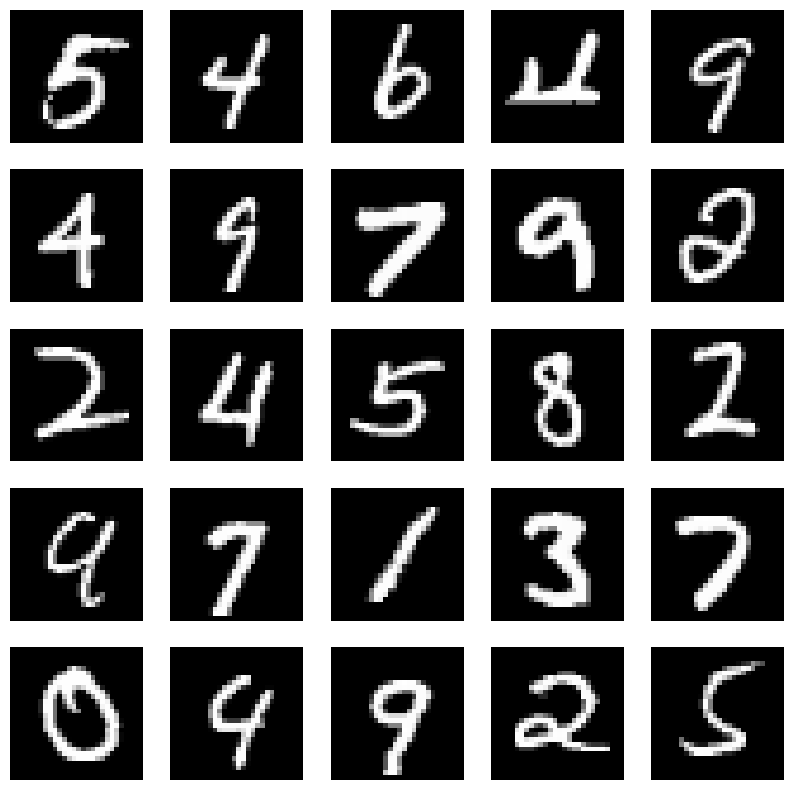

Epoch [2/100], Step [200/938], D Loss: 1.1420, G Loss: 2.6858, Real Score: 0.7654, Fake Score: 0.4717
Epoch [2/100], Step [400/938], D Loss: 0.3846, G Loss: 2.3349, Real Score: 0.8816, Fake Score: 0.1607
Epoch [2/100], Step [600/938], D Loss: 0.3852, G Loss: 2.9501, Real Score: 0.8697, Fake Score: 0.1402
Epoch [2/100], Step [800/938], D Loss: 3.2428, G Loss: 1.0139, Real Score: 0.5445, Fake Score: 0.6863
Epoch [3/100], Step [200/938], D Loss: 0.3447, G Loss: 2.2728, Real Score: 0.8867, Fake Score: 0.1817
Epoch [3/100], Step [400/938], D Loss: 1.1887, G Loss: 1.5161, Real Score: 0.7077, Fake Score: 0.4458
Epoch [3/100], Step [600/938], D Loss: 0.6133, G Loss: 1.7832, Real Score: 0.8149, Fake Score: 0.2644
Epoch [3/100], Step [800/938], D Loss: 2.1361, G Loss: 0.7729, Real Score: 0.4431, Fake Score: 0.5564
Epoch [4/100], Step [200/938], D Loss: 2.3379, G Loss: 1.4591, Real Score: 0.5069, Fake Score: 0.5995
Epoch [4/100], Step [400/938], D Loss: 0.5530, G Loss: 3.2422, Real Score: 0.8142,

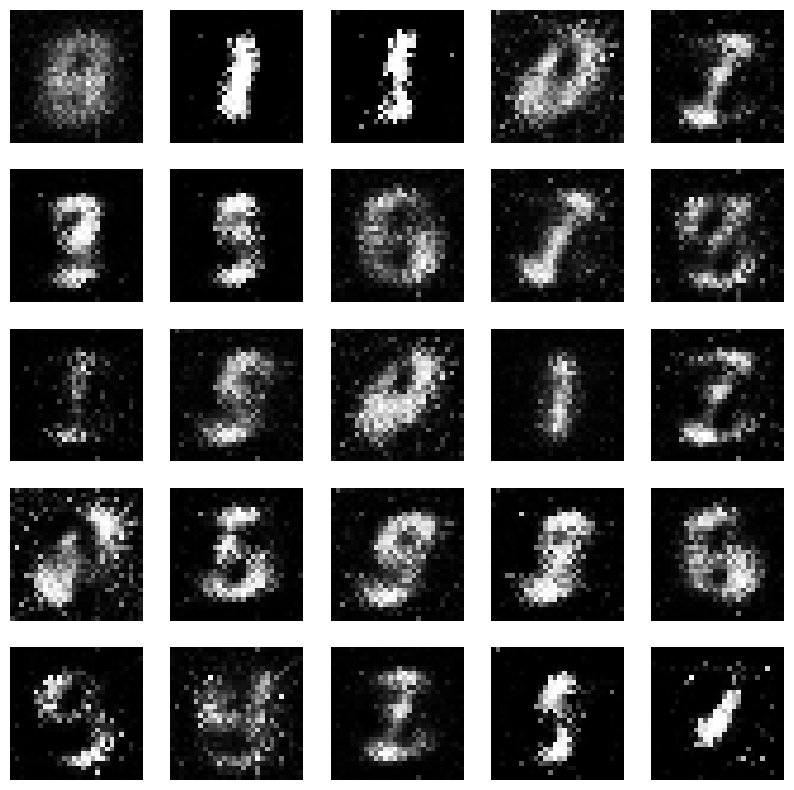

Epoch [11/100], Step [200/938], D Loss: 0.6248, G Loss: 3.2220, Real Score: 0.7992, Fake Score: 0.1990
Epoch [11/100], Step [400/938], D Loss: 0.6839, G Loss: 3.2261, Real Score: 0.7301, Fake Score: 0.1056
Epoch [11/100], Step [600/938], D Loss: 0.9687, G Loss: 2.0493, Real Score: 0.7043, Fake Score: 0.1897
Epoch [11/100], Step [800/938], D Loss: 0.6918, G Loss: 1.7181, Real Score: 0.8430, Fake Score: 0.3036
Epoch [12/100], Step [200/938], D Loss: 0.6442, G Loss: 3.0166, Real Score: 0.8421, Fake Score: 0.2514
Epoch [12/100], Step [400/938], D Loss: 0.5581, G Loss: 2.3125, Real Score: 0.8744, Fake Score: 0.2676
Epoch [12/100], Step [600/938], D Loss: 0.6013, G Loss: 3.7888, Real Score: 0.8438, Fake Score: 0.2368
Epoch [12/100], Step [800/938], D Loss: 0.6829, G Loss: 2.5354, Real Score: 0.8596, Fake Score: 0.3042
Epoch [13/100], Step [200/938], D Loss: 0.4186, G Loss: 2.8763, Real Score: 0.8355, Fake Score: 0.1086
Epoch [13/100], Step [400/938], D Loss: 0.5040, G Loss: 2.5128, Real Scor

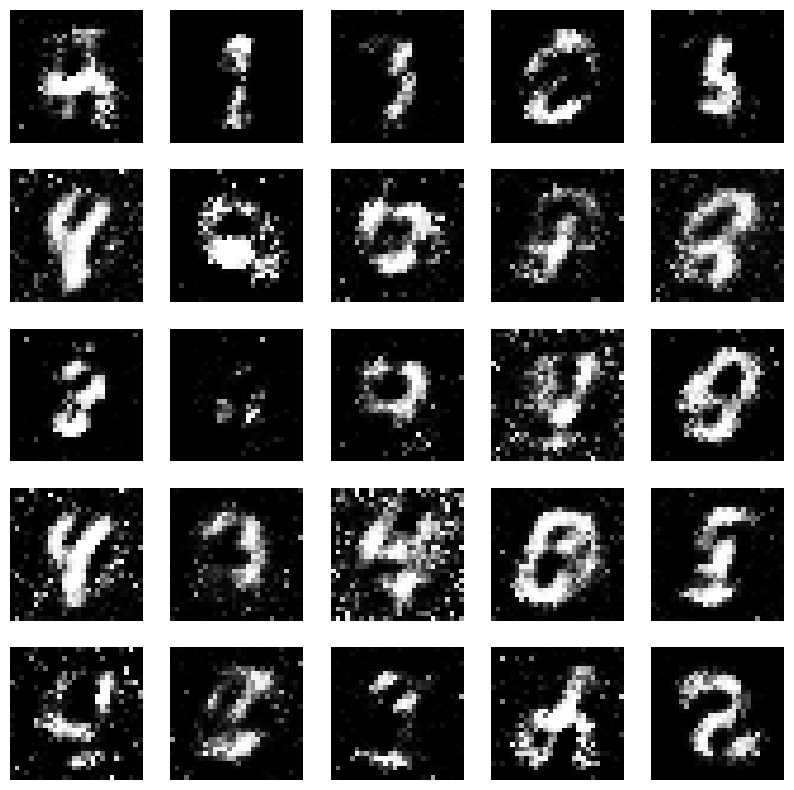

Epoch [21/100], Step [200/938], D Loss: 0.8037, G Loss: 2.2277, Real Score: 0.8856, Fake Score: 0.3836
Epoch [21/100], Step [400/938], D Loss: 0.8883, G Loss: 1.6105, Real Score: 0.6751, Fake Score: 0.1887
Epoch [21/100], Step [600/938], D Loss: 0.6814, G Loss: 1.8322, Real Score: 0.7296, Fake Score: 0.1826
Epoch [21/100], Step [800/938], D Loss: 0.9114, G Loss: 2.1055, Real Score: 0.8484, Fake Score: 0.3965
Epoch [22/100], Step [200/938], D Loss: 0.7478, G Loss: 1.8727, Real Score: 0.6992, Fake Score: 0.1547
Epoch [22/100], Step [400/938], D Loss: 0.7764, G Loss: 1.9663, Real Score: 0.7534, Fake Score: 0.2691
Epoch [22/100], Step [600/938], D Loss: 0.7099, G Loss: 1.1940, Real Score: 0.9117, Fake Score: 0.4008
Epoch [22/100], Step [800/938], D Loss: 0.8586, G Loss: 1.7628, Real Score: 0.6440, Fake Score: 0.1682
Epoch [23/100], Step [200/938], D Loss: 0.6472, G Loss: 1.8461, Real Score: 0.8483, Fake Score: 0.2896
Epoch [23/100], Step [400/938], D Loss: 0.7517, G Loss: 1.6209, Real Scor

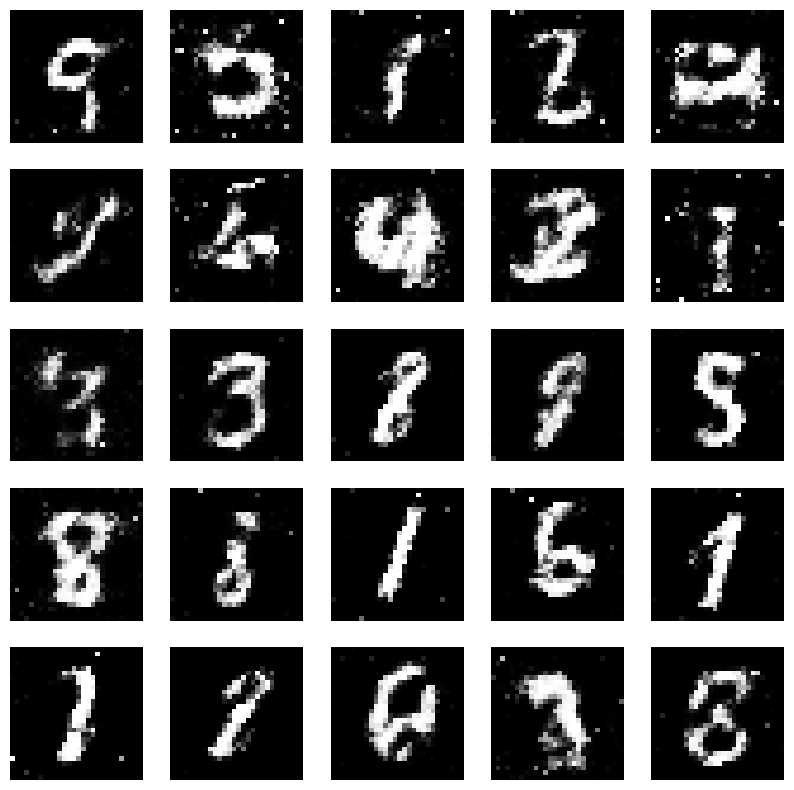

Epoch [31/100], Step [200/938], D Loss: 1.0038, G Loss: 2.2027, Real Score: 0.8021, Fake Score: 0.3622
Epoch [31/100], Step [400/938], D Loss: 0.6681, G Loss: 1.8276, Real Score: 0.7763, Fake Score: 0.2558
Epoch [31/100], Step [600/938], D Loss: 0.7732, G Loss: 1.9891, Real Score: 0.8122, Fake Score: 0.3062
Epoch [31/100], Step [800/938], D Loss: 0.9505, G Loss: 2.2996, Real Score: 0.7912, Fake Score: 0.3875
Epoch [32/100], Step [200/938], D Loss: 0.5775, G Loss: 2.3635, Real Score: 0.8501, Fake Score: 0.2405
Epoch [32/100], Step [400/938], D Loss: 1.0895, G Loss: 1.7395, Real Score: 0.6396, Fake Score: 0.2413
Epoch [32/100], Step [600/938], D Loss: 0.7893, G Loss: 2.3768, Real Score: 0.7749, Fake Score: 0.2428
Epoch [32/100], Step [800/938], D Loss: 0.7528, G Loss: 1.3372, Real Score: 0.7200, Fake Score: 0.2261
Epoch [33/100], Step [200/938], D Loss: 0.7339, G Loss: 1.9207, Real Score: 0.7172, Fake Score: 0.1959
Epoch [33/100], Step [400/938], D Loss: 0.6690, G Loss: 1.8444, Real Scor

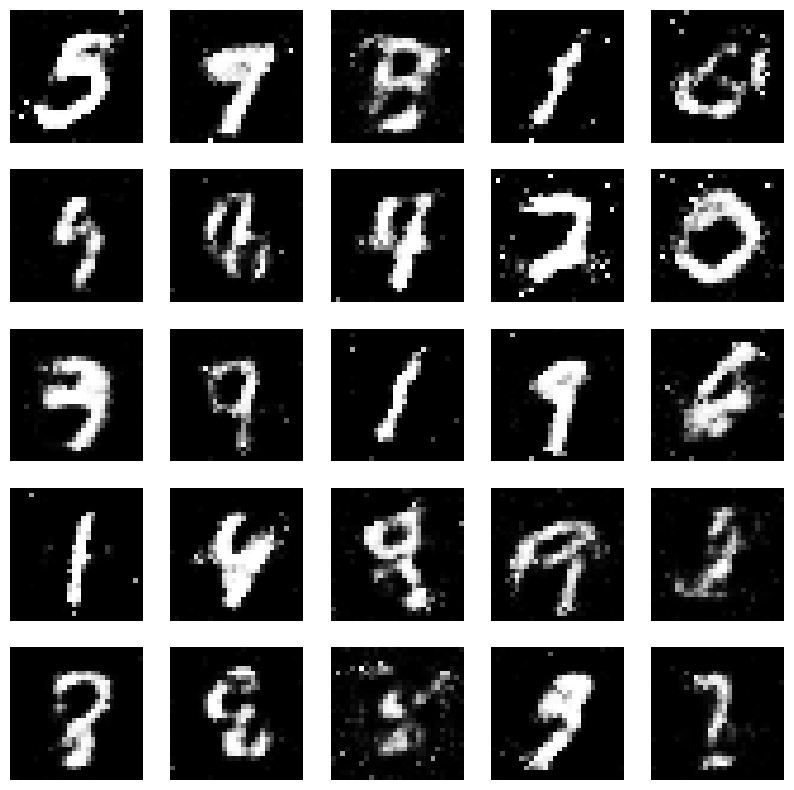

Epoch [41/100], Step [200/938], D Loss: 0.6884, G Loss: 1.5000, Real Score: 0.7999, Fake Score: 0.3039
Epoch [41/100], Step [400/938], D Loss: 0.8169, G Loss: 1.2860, Real Score: 0.6422, Fake Score: 0.2111
Epoch [41/100], Step [600/938], D Loss: 0.7963, G Loss: 2.0782, Real Score: 0.6680, Fake Score: 0.2169
Epoch [41/100], Step [800/938], D Loss: 0.8567, G Loss: 1.6599, Real Score: 0.6968, Fake Score: 0.2623
Epoch [42/100], Step [200/938], D Loss: 0.8722, G Loss: 1.9048, Real Score: 0.7721, Fake Score: 0.3577
Epoch [42/100], Step [400/938], D Loss: 0.8866, G Loss: 1.8646, Real Score: 0.7426, Fake Score: 0.3270
Epoch [42/100], Step [600/938], D Loss: 0.8633, G Loss: 1.5889, Real Score: 0.7628, Fake Score: 0.3285
Epoch [42/100], Step [800/938], D Loss: 0.7563, G Loss: 2.0395, Real Score: 0.8089, Fake Score: 0.3121
Epoch [43/100], Step [200/938], D Loss: 0.7318, G Loss: 2.0934, Real Score: 0.7526, Fake Score: 0.2509
Epoch [43/100], Step [400/938], D Loss: 0.8137, G Loss: 1.6615, Real Scor

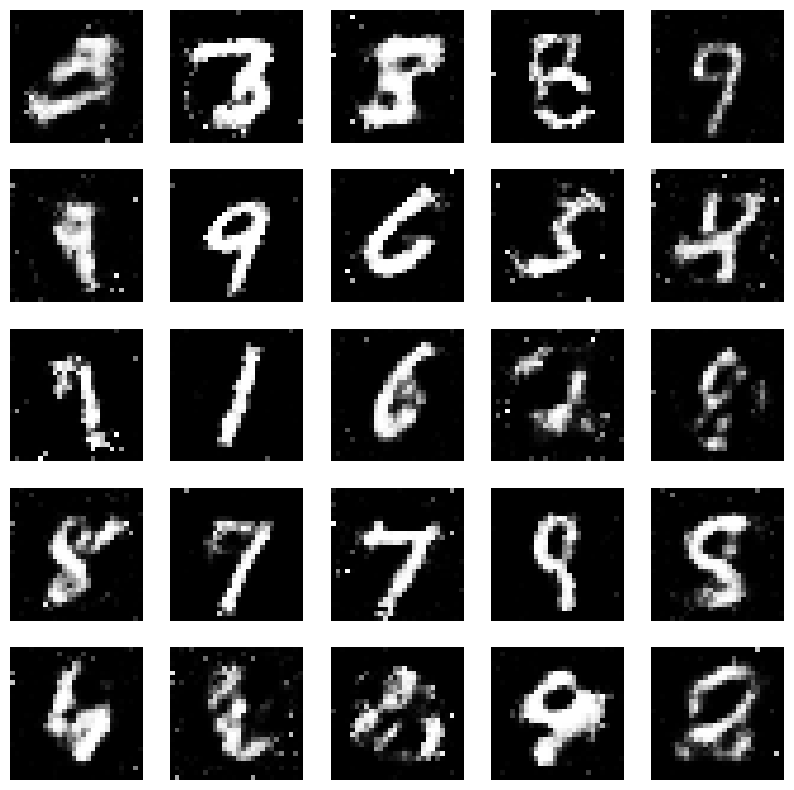

Epoch [51/100], Step [200/938], D Loss: 0.6268, G Loss: 2.0477, Real Score: 0.7820, Fake Score: 0.2199
Epoch [51/100], Step [400/938], D Loss: 0.6254, G Loss: 1.4768, Real Score: 0.7620, Fake Score: 0.2131
Epoch [51/100], Step [600/938], D Loss: 0.8939, G Loss: 1.8760, Real Score: 0.6732, Fake Score: 0.2470
Epoch [51/100], Step [800/938], D Loss: 0.8761, G Loss: 1.9629, Real Score: 0.7218, Fake Score: 0.2818
Epoch [52/100], Step [200/938], D Loss: 0.7856, G Loss: 2.1676, Real Score: 0.6853, Fake Score: 0.2059
Epoch [52/100], Step [400/938], D Loss: 0.9746, G Loss: 1.6963, Real Score: 0.7135, Fake Score: 0.3491
Epoch [52/100], Step [600/938], D Loss: 0.8735, G Loss: 1.6336, Real Score: 0.8097, Fake Score: 0.3729
Epoch [52/100], Step [800/938], D Loss: 0.8972, G Loss: 1.9045, Real Score: 0.7570, Fake Score: 0.3090
Epoch [53/100], Step [200/938], D Loss: 0.8391, G Loss: 2.1010, Real Score: 0.6925, Fake Score: 0.2653
Epoch [53/100], Step [400/938], D Loss: 0.8336, G Loss: 1.5719, Real Scor

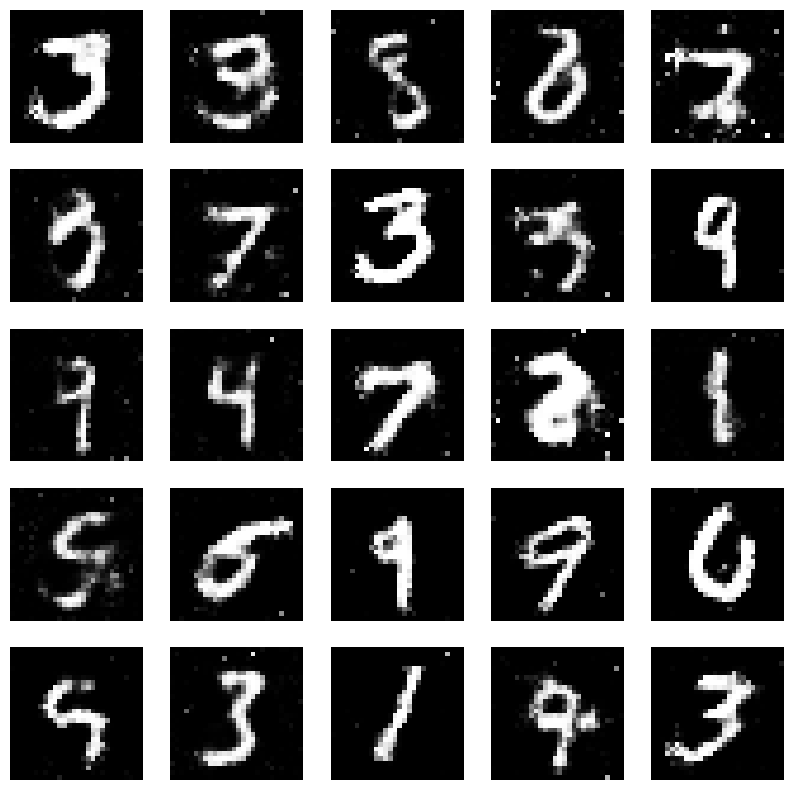

Epoch [61/100], Step [200/938], D Loss: 0.7552, G Loss: 2.0796, Real Score: 0.7884, Fake Score: 0.3172
Epoch [61/100], Step [400/938], D Loss: 0.9268, G Loss: 1.7396, Real Score: 0.7019, Fake Score: 0.2810
Epoch [61/100], Step [600/938], D Loss: 0.9788, G Loss: 1.7098, Real Score: 0.7774, Fake Score: 0.3963
Epoch [61/100], Step [800/938], D Loss: 0.9585, G Loss: 1.6756, Real Score: 0.8757, Fake Score: 0.4584
Epoch [62/100], Step [200/938], D Loss: 0.8264, G Loss: 2.1463, Real Score: 0.7228, Fake Score: 0.2746
Epoch [62/100], Step [400/938], D Loss: 1.0472, G Loss: 1.6107, Real Score: 0.6170, Fake Score: 0.2375
Epoch [62/100], Step [600/938], D Loss: 0.9530, G Loss: 1.5805, Real Score: 0.7503, Fake Score: 0.3482
Epoch [62/100], Step [800/938], D Loss: 0.6816, G Loss: 1.4925, Real Score: 0.7436, Fake Score: 0.2261
Epoch [63/100], Step [200/938], D Loss: 0.9108, G Loss: 1.6734, Real Score: 0.6054, Fake Score: 0.2080
Epoch [63/100], Step [400/938], D Loss: 0.9287, G Loss: 1.8000, Real Scor

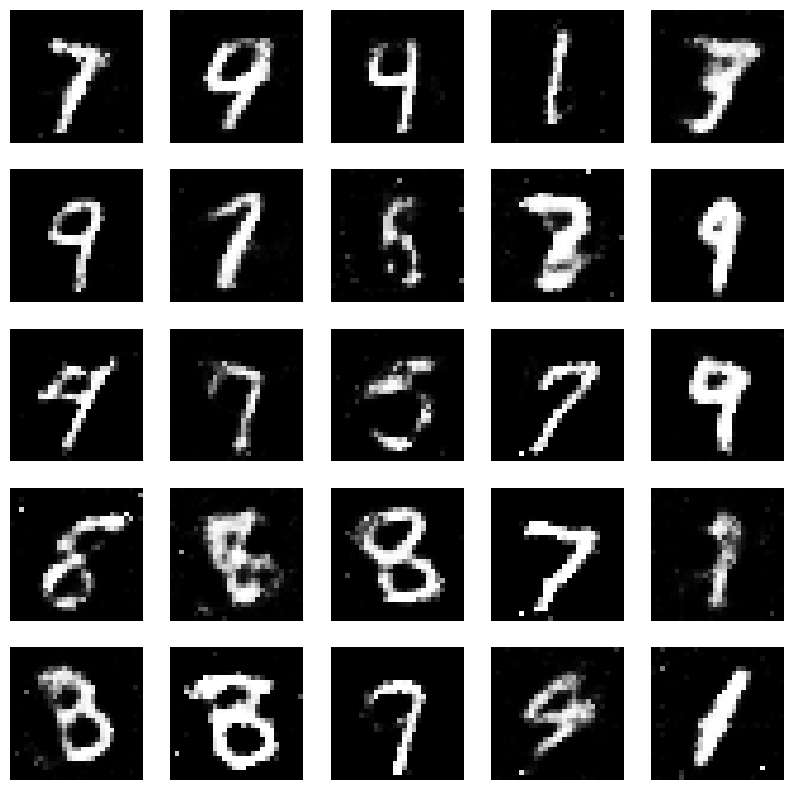

Epoch [71/100], Step [200/938], D Loss: 0.7945, G Loss: 1.6407, Real Score: 0.7653, Fake Score: 0.3074
Epoch [71/100], Step [400/938], D Loss: 0.7644, G Loss: 1.6343, Real Score: 0.7071, Fake Score: 0.2300
Epoch [71/100], Step [600/938], D Loss: 0.8666, G Loss: 1.8091, Real Score: 0.7068, Fake Score: 0.2683
Epoch [71/100], Step [800/938], D Loss: 0.7326, G Loss: 1.4562, Real Score: 0.8235, Fake Score: 0.3346
Epoch [72/100], Step [200/938], D Loss: 0.7258, G Loss: 1.7977, Real Score: 0.7626, Fake Score: 0.2706
Epoch [72/100], Step [400/938], D Loss: 0.8723, G Loss: 1.5163, Real Score: 0.6983, Fake Score: 0.2882
Epoch [72/100], Step [600/938], D Loss: 0.8250, G Loss: 1.6724, Real Score: 0.6747, Fake Score: 0.2362
Epoch [72/100], Step [800/938], D Loss: 0.7835, G Loss: 1.3461, Real Score: 0.7413, Fake Score: 0.2762
Epoch [73/100], Step [200/938], D Loss: 0.8827, G Loss: 2.2075, Real Score: 0.7204, Fake Score: 0.2947
Epoch [73/100], Step [400/938], D Loss: 1.0541, G Loss: 1.4375, Real Scor

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# تنظیمات
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64
z_dim = 100
lr = 0.0002
epochs = 100

# آماده‌سازی داده
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# معماری شبکه‌ها
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x.view(-1, 784))

# ایجاد شبکه‌ها و تعریف تابع هزینه و بهینه‌ساز
generator = Generator().to(device)
discriminator = Discriminator().to(device)
criterion = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = optim.Adam(generator.parameters(), lr=lr)

# تابعی برای آموزش شبکه‌ها
def train_discriminator(images):
    # اطمینان حاصل کنید که اندازه بچ تصاویر با اندازه بچ‌های مورد انتظار برای شبکه‌ها همخوانی دارد
    images = images.view(-1, 28 * 28).to(device)

    # آموزش دهیم که تشخیص دهد که عکس‌ها از دیتاست واقعی یا تولیدی هستند
    real_labels = torch.ones(images.size(0), 1, device=device)
    fake_labels = torch.zeros(images.size(0), 1, device=device)

    # آموزش دادن بر داده‌های واقعی
    outputs = discriminator(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # آموزش دادن بر داده‌های تولیدی
    z = torch.randn(images.size(0), z_dim, device=device)
    fake_images = generator(z)
    outputs = discriminator(fake_images.detach())
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # تجمیع تابع هزینه و به‌روزرسانی شبکه
    d_loss = d_loss_real + d_loss_fake
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    return d_loss, real_score, fake_score


def train_generator():
    # آموزش دهیم که تشخیص دهد که عکس‌ها واقعی هستند
    real_labels = torch.ones(batch_size, 1, device=device)

    # آموزش دادن بر داده‌های تولیدی و به‌روزرسانی شبکه
    z = torch.randn(batch_size, z_dim, device=device)
    fake_images = generator(z)
    outputs = discriminator(fake_images)
    g_loss = criterion(outputs, real_labels)
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    return g_loss, fake_images

# آموزش GAN
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
for epoch in range(epochs):
    for i, (images, _) in enumerate(train_loader):
        images = images.to(device)

        # آموزش دهیم تا شبکه‌های تولیدکننده و تشخیص‌دهنده را آموزش دهیم
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # ذخیره کردن و چاپ آمار و پیشرفت
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], '
                  f'D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}, '
                  f'Real Score: {real_score.mean().item():.4f}, Fake Score: {fake_score.mean().item():.4f}')

    # نمونه‌برداری و چاپ نمونه‌های تولید شده در انتهای هر ایپاک
    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        fig, axes = plt.subplots(5, 5, figsize=(10,10))
        for i, ax in enumerate(axes.flat):
            ax.imshow(images[i].squeeze().cpu().detach().numpy(), cmap='gray')
            ax.axis('off')
        plt.show()
    elif (epoch+1) % 10 == 0:
        images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
        fig, axes = plt.subplots(5, 5, figsize=(10,10))
        for i, ax in enumerate(axes.flat):
            ax.imshow(images[i].squeeze().cpu().detach().numpy(), cmap='gray')
            ax.axis('off')
        plt.show()
